# Analyse final shaft temperature
In this notebook I will analyse the extracted corrected shaft temperature.

In [1]:
import pickle
import pandas as pd
import statistics
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
from shutil import copy2 as copy_file
import matplotlib.dates as mdates

from my_func_mvw.functions import read_pickle, calc_stat_of_difference, statistic_plot
from my_func_mvw.functions_import_my_database import import_processed_shaft_temperatures
%load_ext autoreload
%autoreload 2

######################### Input ######################################################
path_DTS_processed = r"..\Alsdorf\Daten\DTS_processed"
importer="pickel" #csv pickel
# for some plots I use plotly.express, you may need to install that. 
# You can set the following to False if you dont want to see them.
show_big_plots = False #True False
plot_save = True # True False
######################################################################################
masterthesis_save=False # True False

if show_big_plots:
    import plotly
    import plotly.express as px
    import kaleido

print("Some Version information of the imported packages")
print(f"pandas: {pd.__version__}")
print(f"pickle: {pickle.format_version}")
!python --version

Some Version information of the imported packages
pandas: 1.3.4
pickle: 4.0
Python 3.8.12


In [2]:
#Import processed temperatures of the shaft
Schacht_7and8_down, Schacht_7and8_up = import_processed_shaft_temperatures(path_DTS_processed, importer=importer)

In [3]:
# up und down sind nicht perfekt auf einander abgestimmt von der Tiefe. 
# Eine perfekte Abstimmung wird man nie erreichen, da es nur diskrete Messpunkte gibt. 
# D.h. der Index, also die Tiefenangaben zu den Temperaturen sind nicht ganz richtig.

# Dies liegt daran, dass ich entlang des Kabels mir die ABstände raus suche, bei denen ich denke, dass der Schacht beginnt. 
# Dieses Auswählen muss ich so machen, dass das Kabel hoch unf runter genau gleich viele Messpunkte hat. 
# Die Messpunkte von hoch und runter sind aber natürlich nicht notwendigerweise genau auf der gleichen Höhe, 
# da der Umknickpunkt nicht auf die Messpunkte abgestimmt ist und die ersten (bzw letzen) Messpunkt nicht exakt bei 0 sind.

In [4]:
def plot_save_func(filename_save):
    """saves the plots as png and copies them to my_database
    copied from my_database script"""
    save_path = "pictures/" + filename_save + ".png"
    plt.savefig(save_path)

In [5]:
# Plot the data
#https://plotly.com/python-api-reference/generated/plotly.express.imshow.html
plot="you dont want this plot"
if show_big_plots:
    plot = px.imshow(Schacht_7and8_down,labels={"color":"Temperature"},zmin=15,zmax=35,
                    title="Avearage Channel 7 and 8 shaft, down")
if plot_save and show_big_plots:
    #https://plotly.com/python/static-image-export/
    # filename = "\carpet_final_temperature_EGRT-Cable_down.png"
    # plot.write_image(".\\pictures" + filename)
    # exports the plot as html, so the hover features are avaible
    filename = "\carpet_live_final_temperature_EGRT-Cable_down.html"
    plotly.offline.plot(plot, filename=".\\pictures" + filename)
plot
# looks the same
#px.imshow(Schacht_7and8_up,labels={"color":"Temperature"},zmin=15,zmax=35,title="Avearage Channel 7 and 8 shaft, up")

'you dont want this plot'

In [6]:
# Plot Difference between up and down
diff_up_down = Schacht_7and8_down - Schacht_7and8_up
if show_big_plots:
    plot=px.imshow(diff_up_down,labels={"color":"Difference"},zmin=-1,zmax=1, title="Difference of up and down")
plot

'you dont want this plot'

In [7]:
# calc mean and standart deviation for every depth

diff_statistic = calc_stat_of_difference(diff_up_down)
stdev_mean=diff_statistic.loc["stdev"].mean()

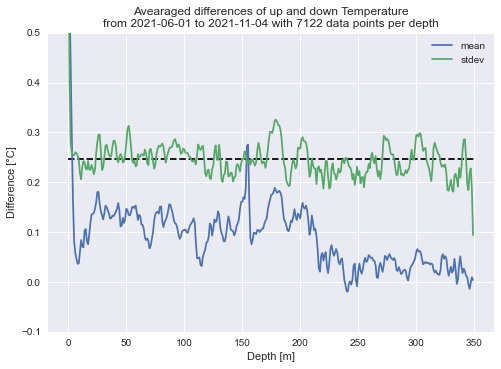

In [8]:
# Plot Difference Statistics

plt.plot(diff_statistic.loc["mean"].index,diff_statistic.loc["mean"].values,label="mean")
plt.plot(diff_statistic.loc["stdev"].index,diff_statistic.loc["stdev"].values,label="stdev")
plt.hlines([stdev_mean],0,350,color="black",linestyle="--")
plt.ylim(-0.1,0.5)
plt.xlabel("Depth [m]")
plt.ylabel("Difference [°C]")
plt.legend()
min_date = diff_up_down.index.min().strftime("%Y-%m-%d")
max_date = diff_up_down.index.max().strftime("%Y-%m-%d")
n = len(diff_up_down.index)
plt.title(f"Avearaged differences of up and down Temperature\nfrom {min_date} to {max_date} with {n} data points per depth")
plt.show()

In [9]:
# Both plots are very similar, for interpretation one of them is sufficient. Its just to show that they are very similar
# A lot of these plots is copied from Daniels plot from Alsdorf_plot.py

plot_up_down=False
if plot_up_down:
    depth = [Schacht_7and8_down.columns,Schacht_7and8_up.columns] # depth is the same for both
    # fore every depth minimum along all dates
    tempmin = [Schacht_7and8_down.min(axis = 0),Schacht_7and8_up.min(axis = 0)]
    tempmax = [Schacht_7and8_down.max(axis = 0),Schacht_7and8_up.max(axis = 0)]
    tempmean = [Schacht_7and8_down.mean(axis = 0),Schacht_7and8_up.mean(axis = 0)]
    tempstd = [Schacht_7and8_down.std(axis = 0),Schacht_7and8_up.std(axis = 0)]

    label_2 = 'Mean' 
    labelmin = 'Min - Max'
    labelstd = 'Standartdeviation'
    fig , axs=plt.subplots(1,2,figsize=[14,7], sharey = True,constrained_layout=True)
    fig.suptitle("Statisitc of Temperature Change over time",fontsize=14)
    for i in range(len(axs)):
        axs[i].plot(tempmean[i], depth[i], color='#10366f', alpha = 0.8, label = label_2)
        axs[i].fill_betweenx(depth[i], tempmin[i], tempmax[i],
                        #facecolor="blue",           # The fill color
                        color='#7fc7ff',             # The outline color
                        alpha=0.3, label = labelmin) # Transparency of the fill
        axs[i].fill_betweenx(depth[i], tempmean[i] - tempstd[i], tempmean[i] + tempstd[i],
                        # facecolor="#1CB992",       # The fill color
                        color="#c52b2f",             # The outline color
                        alpha=0.3, label = labelstd) # Transparency of the fill
        # axs[i].fill_betweenx(depth[i], tempmean[i] - 0.22, tempmean[i] + 0.22,
        #             # facecolor="#1CB992",       # The fill color
        #             color="black",             # The outline color
        #             alpha=0.3, label = "Expected Standartdeviation") # Transparency of the fill

        axs[i].set_ylim([(depth[i].max() + 0.05 * (depth[i].max()-depth[i].min())), 
                        (depth[i].min() - 0.05 * (depth[i].max() - depth[i].min()))])
        axs[i].legend()
        axs[i].set_ylabel("Depth [m]")
        axs[i].set_xlabel("Temperature [°C]")
        axs[i].set_xlim(18,28)

    axs[1].yaxis.set_ticks_position("right") 
    axs[1].yaxis.set_label_position("right") 
    axs[0].set_title("Down")
    axs[1].set_title("Up")
    if plot_save:
        plot_save_func("final_temperature_EGRT-Cable_up_and_down")
    plt.show()

# Plot 
Dort wird nur down dargestellt

7 dates with nan have been added


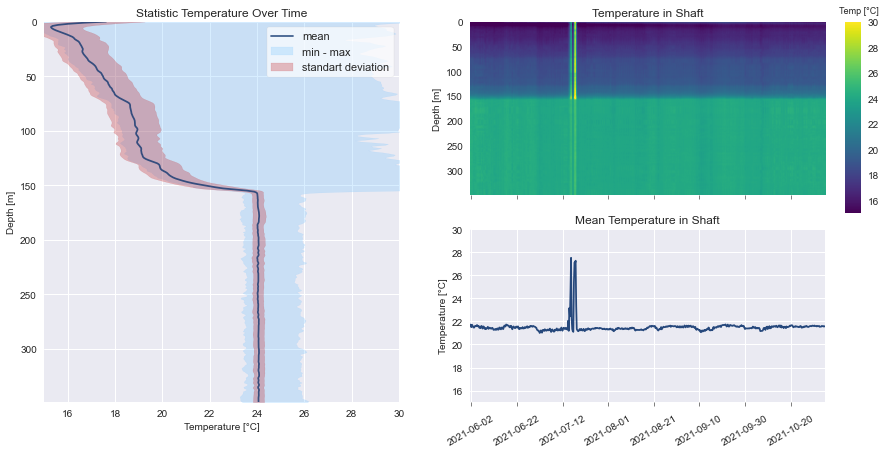

In [10]:
shaft_for_plot_func={}
channel="7and8down"
shaft_for_plot_func[channel] = Schacht_7and8_down
statistic_plot(data_shaft=shaft_for_plot_func,date_min_max=[0,-1],c=channel,temp_ax_min=15, temp_ax_max=30, sample_hours = 6)

if plot_save and channel == "7and8down":
    filename=f"\\temperature_in_shaft_chan{channel}_statistic"
    plt.savefig(r".\pictures" + filename + ".png", bbox_inches="tight")
    if masterthesis_save:
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs\chap4" + filename + ".pdf", format="pdf",bbox_inches="tight")
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs_raster\chap4" + filename + ".png", format="png",bbox_inches="tight",dpi=300)

plt.show()